In [1]:
import os
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline

In [2]:
user_name = os.environ.get('DB_USER')
password = os.environ.get('DB_PASSWORD')
DB_NAME = 'BacterialGrowth'

# Database function: execute

In [4]:
def execute(phrase):
    """This function create a connection to the database and execute a command.
    :param phrase: str SQL sentence to execute
    :return: list of str received from the database after command execution.
    """
    try:
        cnx = mysql.connector.connect(user=user_name, password=password,host='localhost',database=DB_NAME)
        cnx.get_warnings = True
        cursor = cnx.cursor()
        cursor.execute(phrase)
        res = []
        for row in cursor:
            res.append(row)

        warnings = cursor.fetchwarnings()
        if warnings: 
            for i in range(len(warnings)):
                print("Warning - "+warnings[i][2])
        cursor.close()
        cnx.commit()
        cnx.close()
        return res
    except mysql.connector.Error as err:
        print("Something went wrong: {}".format(err))


# Abundance plot of bacteria in a single replicate


In [7]:
phrase = "SELECT abundanceFile FROM TechnicalReplicate WHERE abundanceFile = '/Users/julia/bacterialGrowth_thesis/Data/experiments/101/101.1/1/abundance_file.txt'"


In [8]:
res = execute(phrase)

In [9]:
res

[('/Users/julia/bacterialGrowth_thesis/Data/experiments/101/101.1/1/abundance_file.txt',)]

In [10]:
growth_df = pd.read_csv(res[0][0], sep=" ")
growth_df.head()

,time,OD,liquidtotalcount,liquidactivecount
0,0,0.014,4753,4109
1,4,0.024,17257,16616
2,8,0.211,228160,227030
3,12,0.657,763902,762292
4,16,0.868,1728989,1726829


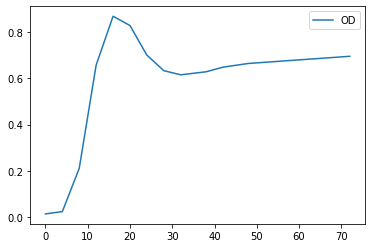

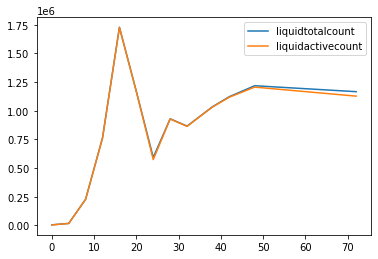

In [11]:
plt.plot('time', 'OD', data=growth_df, linestyle='-')
plt.legend()
plt.show()

plt.plot('time', 'liquidtotalcount', data=growth_df, linestyle='-')
plt.plot('time', 'liquidactivecount', data=growth_df, linestyle='-')
plt.legend()
plt.show()

In [45]:
def plotSeveralColumns(df):
    if len(df.columns) > 1:
        for column in df:
            if column != 'time':
                plt.plot('time', column, data=df, linestyle='-')
        plt.legend()
        plt.show()

In [46]:
def plotSeveralColumns(df, regex):
    
    headers = getMatchingList(regex, df)
    data = getIntersectionColumns(df, headers)
    
    if len(data.columns) > 1:
        for column in data:
            if column != 'time':
                plt.plot('time', column, data=data, linestyle='-')
        plt.legend()
        plt.show()

In [23]:
def getMatchingList (regex, lst):
    '''
    This function takes a regex expression and returns a list with all the matching words in the given lst
    '''
    res = []
    for word in lst:
        if regex.findall(word):
            res.append(word)
    return res

def getIntersectionColumns(df, columns):
    res = df[df.columns.intersection(columns)]
    return res

In [83]:
od_regex = re.compile(r'.*time.* | .*OD.*', flags=re.I | re.X)
count_regex = re.compile(r'.*time.* | .*count.*', flags=re.I | re.X)
qpcr_regex = re.compile(r'.*time.* | .*qpcr.*', flags=re.I | re.X)
rnaseq_regex = re.compile(r'.*time.* | .*rna.*', flags=re.I | re.X)

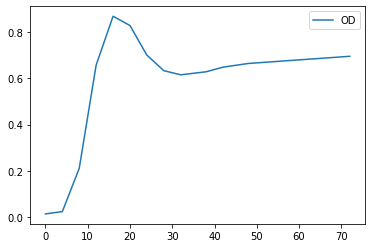

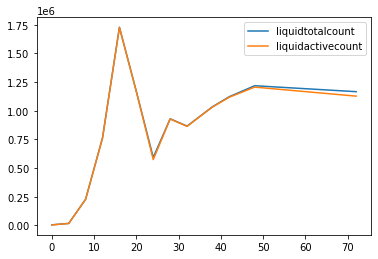

In [49]:
plotSeveralColumns(growth_df, od_regex)
plotSeveralColumns(growth_df, count_regex)
plotSeveralColumns(growth_df, qpcr_regex)
plotSeveralColumns(growth_df, rnaseq_regex)

## TO DO:
* Add title
* Add xlabel and ylabel

# Abundance plot of bacteria in a single experiment/perturbation (mean and standard deviation os a set of replicates) 

In [185]:
phrase_abundance = "SELECT abundanceFile FROM TechnicalReplicate WHERE perturbationId = '101.1'"
phrase_metabolites = "SELECT metabolitesFile FROM TechnicalReplicate WHERE perturbationId = '101.1'"

In [186]:
abundance_files = execute(phrase_abundance)
metabolites_files = execute(phrase_metabolites)

In [187]:
metabolites_files

[('/Users/julia/bacterialGrowth_thesis/Data/experiments/101/101.1/1/metabolites_file.txt',),
 ('/Users/julia/bacterialGrowth_thesis/Data/experiments/101/101.1/2/metabolites_file.txt',),
 ('/Users/julia/bacterialGrowth_thesis/Data/experiments/101/101.1/3/metabolites_file.txt',),
 ('/Users/julia/bacterialGrowth_thesis/Data/experiments/101/101.1/4/metabolites_file.txt',),
 ('/Users/julia/bacterialGrowth_thesis/Data/experiments/101/101.1/5/metabolites_file.txt',),
 ('/Users/julia/bacterialGrowth_thesis/Data/experiments/101/101.1/6/metabolites_file.txt',),
 ('/Users/julia/bacterialGrowth_thesis/Data/experiments/101/101.1/7/metabolites_file.txt',),
 ('/Users/julia/bacterialGrowth_thesis/Data/experiments/101/101.1/8/metabolites_file.txt',),
 ('/Users/julia/bacterialGrowth_thesis/Data/experiments/101/101.1/9/metabolites_file.txt',)]

In [121]:
def getMeanStd(records, regex):
    record = pd.read_csv(records[0][0], sep=" ")
    headers = getMatchingList(regex, record)
    dfs = pd.DataFrame(columns=range(1))
    dfs.set_axis(['time'], axis='columns', inplace=True)
    dfs['time'] = record['time']
    
    for header in headers:
        if header != 'time':
            df = pd.DataFrame(columns=range(len(records)+1)) #Each column will be the value of each record

            # Fill the df parsing all the records' files
            for i, record in enumerate(records, 1):
                record_df = pd.read_csv(record[0], sep=" ")
                df.iloc[:,i] = record_df[header]

            # Calculate and keep mean and std
            df_res = pd.DataFrame(columns=range(3))
            df_res.set_axis(['time', header+'_mean', header+'_std'], axis='columns', inplace=True)
            df_res['time'] = record_df['time']
            df_res[header+'_mean'] = df.iloc[:,1:].mean(axis=1, numeric_only=True)
            df_res[header+'_std'] = df.iloc[:,1:].std(axis=1, numeric_only=True)

            dfs = pd.merge(dfs, df_res, on='time')
    
    return dfs

In [183]:
def getMeanStd(records, regex=''):
    record = pd.read_csv(records[0][0], sep=" ")
    if regex != '':
        headers = getMatchingList(regex, record)
    else:
        headers = record.columns
    
    dfs = pd.DataFrame(columns=range(1))
    dfs.set_axis(['time'], axis='columns', inplace=True)
    dfs['time'] = record['time']
    
    for header in headers:
        if header != 'time':
            df = pd.DataFrame(columns=range(len(records)+1)) #Each column will be the value of each record

            # Fill the df parsing all the records' files
            for i, record in enumerate(records, 1):
                record_df = pd.read_csv(record[0], sep=" ")
                df.iloc[:,i] = record_df[header]

            # Calculate and keep mean and std
            df_res = pd.DataFrame(columns=range(3))
            df_res.set_axis(['time', header+'_mean', header+'_std'], axis='columns', inplace=True)
            df_res['time'] = record_df['time']
            df_res[header+'_mean'] = df.iloc[:,1:].mean(axis=1, numeric_only=True)
            df_res[header+'_std'] = df.iloc[:,1:].std(axis=1, numeric_only=True)

            dfs = pd.merge(dfs, df_res, on='time')
    
    return dfs

In [202]:
def plotFigure(dfs):
    if len(dfs.columns) > 1:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.set_xlabel('time', fontsize = 16)
        ax.set_ylabel('abundance', fontsize = 16)

        cmap = plt.get_cmap(name='tab10')

        for i in range(1,len(dfs.columns),2):
            ax.errorbar(dfs.iloc[:,0], dfs.iloc[:,i], yerr = dfs.iloc[:,i+1], color = cmap(i-1))

        plt.show()

### Abundances

`regex = od_regex`

In [203]:
od_msd = getMeanStd(abundance_files, regex=od_regex)
count_msd = getMeanStd(abundance_files, regex=count_regex)
qpcr_msd = getMeanStd(abundance_files, regex=qpcr_regex)
rnaseq_msd = getMeanStd(abundance_files, regex=rnaseq_regex)

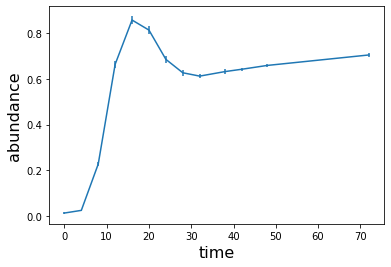

In [204]:
plotFigure(od_msd)

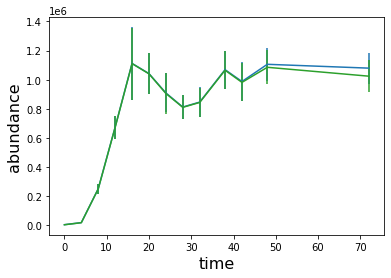

In [205]:
plotFigure(count_msd)

In [206]:
plotFigure(qpcr_msd)

### Metabolites
`regex = ''`

In [192]:
met_msd = getMeanStd(metabolites_files, regex='')

In [193]:
met_msd

,time,Glucose_mean,Glucose_std,Pyruvate_mean,Pyruvate_std,Succinate_mean,Succinate_std,Lactate_mean,Lactate_std,Formate_mean,Formate_std,Acetate_mean,Acetate_std,Neu5Ac_mean,Neu5Ac_std
0,0,7.580000,0.036742,7.972222,0.040859,0.624444,0.023511,0.564444,0.043333,1.631111,0.231703,2.181111,0.021473,1.282222,0.008333
1,4,7.533333,0.042720,7.982222,0.044659,0.647778,0.014814,0.575556,0.011304,1.770000,0.045000,2.240000,0.008660,1.274444,0.007265
2,8,6.817778,0.059325,8.228889,0.058405,1.316667,0.064031,0.616667,0.018708,2.477778,0.084080,3.223333,0.060415,1.263333,0.008660
3,12,4.271111,0.093601,6.860000,0.248345,3.822222,0.090523,1.276667,0.057009,3.120000,0.391280,6.211111,0.143653,1.268889,0.019003
4,16,1.354444,0.053877,3.303333,0.195959,6.291111,0.116022,3.067778,0.139712,2.965556,0.048247,9.657778,0.099093,1.267778,0.006667
5,20,0.218889,0.026194,1.204444,0.169640,7.871111,0.125344,3.924444,0.325811,2.976667,0.093808,11.683333,0.498071,1.262222,0.021082
6,24,0.148889,0.003333,0.860000,0.013229,8.731111,0.082832,3.778889,0.190095,2.956667,0.049244,12.103333,0.042131,1.270000,0.007071
7,28,0.136667,0.005000,0.821111,0.016159,9.033333,0.147479,3.700000,0.155804,2.968889,0.127715,12.246667,0.057228,1.274444,0.007265
8,32,0.137778,0.006667,0.794444,0.016667,9.144444,0.118122,3.748889,0.164503,2.931111,0.060300,12.235556,0.039087,1.280000,0.010000
9,38,0.141111,0.003333,0.766667,0.014142,9.226667,0.157242,3.750000,0.169189,2.944444,0.093423,12.222222,0.031136,1.333333,0.005000


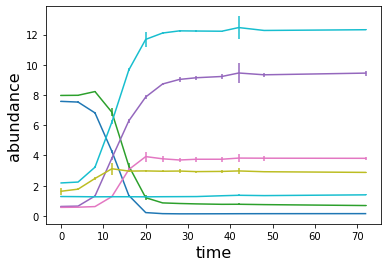

In [194]:
plotFigure(met_msd)